In [6]:
from numpy import *
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import preprocessing
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#df = pd.read_csv("NoSqli_Dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/Thesis Resources/dataset/NoSql_Injection/NoSqli_Dataset.csv")
df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,ClassLabel
0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [10]:

X = df.drop(['ClassLabel'],axis='columns')
Y = df['ClassLabel']

In [ ]:
Y.value_counts()

0    801
1    203
Name: ClassLabel, dtype: int64

In [ ]:
X.head(2)

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0,0,0,1,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0


In [ ]:
Y.head(5)

0    0
1    1
2    0
3    0
4    0
Name: ClassLabel, dtype: int64

# Evaluation of Best Classification Model Using GridSearchCV(with handling imbalanced data)

In [ ]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



#this method should be updated with more ML models
def benchmark(sampling_type,x,y):
    #lr = LogisticRegression(penalty = 'l2')
    #param_grid = {'C':[0.01,0.1,1,10]}
    scores = []

    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}

    for model_name, mp in model_params.items():
        grid =  GridSearchCV(estimator=mp['model'],param_grid= mp['params'],scoring='accuracy', cv=10,n_jobs=-1,verbose=2)
        grid = grid.fit(x, y)
        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        print(report)
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']

        
        # print("precision: ")
        # print(macro_precision)
        # print("recall: ")
        # print(macro_recall)
        # print("f1-score: ")
        # print(macro_f1)
        # print("accuracy: ")
        # print(accuracy)
      
        
        scores.append({
            'sampling_type':sampling_type,
            'model': model_name.upper(),
            'best_score': grid.best_score_,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,    
        })
    
        #gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=10, verbose=2)
        #gs = gs.fit(X.values,Y.values.ravel())
    return scores

def transform(transformer,X,Y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,Y_resampled = transformer.fit_sample(X.values,Y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(Y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Apply transformations to dataset

In [ ]:
datasets = []
datasets.append(("base",X,Y))
datasets.append(transform(SMOTE(n_jobs=-1),X,Y))
datasets.append(transform(RandomOverSampler(),X,Y))
datasets.append(transform(NearMiss(n_jobs=-1),X,Y))
datasets.append(transform(RandomUnderSampler(),X,Y))
datasets.append(transform(SMOTEENN(),X,Y))
datasets.append(transform(SMOTETomek(),X,Y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Determine best hyperparameters

In [ ]:
benchmark_scores = []
for sample_type,X,Y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores = benchmark_scores + (benchmark(sample_type,X,Y))
    print('______________________________________________________________')



______________________________________________________________
base
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9634300126103404, 'recall': 0.9538077403245943, 'f1-score': 0.958594730238394, 'support': 801}, 'Malicious': {'precision': 0.8246445497630331, 'recall': 0.8571428571428571, 'f1-score': 0.8405797101449276, 'support': 203}, 'accuracy': 0.9342629482071713, 'macro avg': {'precision': 0.8940372811866868, 'recall': 0.9054752987337257, 'f1-score': 0.8995872201916608, 'support': 1004}, 'weighted avg': {'precision': 0.9353688084689028, 'recall': 0.9342629482071713, 'f1-score': 0.9347331275700935, 'support': 1004}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9698162729658792, 'recall': 0.9225967540574282, 'f1-score': 0.945617402431222, 'support': 801}, 'Malicious': {'precision': 0.743801652892562, 'recall': 0.8866995073891626, 'f1-score': 0.8089887640449438, 'support': 203}, 'accuracy': 0.9153386454183267, 'macro avg': {'precision': 0.8568089629292206, 'recall': 0.9046481307232954, 'f1-score': 0.8773030832380829, 'support': 1004}, 'weighted avg': {'precision': 0.9241180977916926, 'recall': 0.9153386454183267, 'f1-score': 0.917992289291367, 'support': 1004}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9695817490494296, 'recall': 0.9550561797752809, 'f1-score': 0.9622641509433961, 'support': 801}, 'Malicious': {'precision': 0.8325581395348837, 'recall': 0.8817733990147784, 'f1-score': 0.8564593301435407, 'support': 203}, 'accuracy': 0.9402390438247012, 'macro avg': {'precision': 0.9010699442921566, 'recall': 0.9184147893950296, 'f1-score': 0.9093617405434684, 'support': 1004}, 'weighted avg': {'precision': 0.9418767762093372, 'recall': 0.9402390438247012, 'f1-score': 0.9408713435505967, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9695817490494296, 'recall': 0.9550561797752809, 'f1-score': 0.9622641509433961, 'support': 801}, 'Malicious': {'precision': 0.8325581395348837, 'recall': 0.8817733990147784, 'f1-score': 0.8564593301435407, 'support': 203}, 'accuracy': 0.9402390438247012, 'macro avg': {'precision': 0.9010699442921566, 'recall': 0.9184147893950296, 'f1-score': 0.9093617405434684, 'support': 1004}, 'weighted avg': {'precision': 0.9418767762093372, 'recall': 0.9402390438247012, 'f1-score': 0.9408713435505967, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9730458221024259, 'recall': 0.9013732833957553, 'f1-score': 0.9358392741412831, 'support': 801}, 'Malicious': {'precision': 0.6984732824427481, 'reca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9459459459459459, 'recall': 0.9612983770287141, 'f1-score': 0.9535603715170278, 'support': 801}, 'Malicious': {'precision': 0.8368421052631579, 'recall': 0.7832512315270936, 'f1-score': 0.8091603053435116, 'support': 203}, 'accuracy': 0.9252988047808764, 'macro avg': {'precision': 0.8913940256045519, 'recall': 0.8722748042779038, 'f1-score': 0.8813603384302697, 'support': 1004}, 'weighted avg': {'precision': 0.9238861056485296, 'recall': 0.9252988047808764, 'f1-score': 0.9243639437946933, 'support': 1004}}
______________________________________________________________
______________________________________________________________
SMOTE
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8695652173913043, 'recall': 0.9488139825218477, 'f1-score': 0.9074626865671641, 'support': 801}, 'Malicious': {'precision': 0.9436813186813187, 'recall': 0.8576779026217228, 'f1-score': 0.8986265533028123, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9066232680363115, 'recall': 0.9032459425717853, 'f1-score': 0.9030446199349882, 'support': 1602}, 'weighted avg': {'precision': 0.9066232680363115, 'recall': 0.9032459425717853, 'f1-score': 0.9030446199349882, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8732876712328768, 'recall': 0.9550561797752809, 'f1-score': 0.9123434704830055, 'support': 801}, 'Malicious': {'precision': 0.9504132231404959, 'recall': 0.8614232209737828, 'f1-score': 0.9037328094302555, 'support': 801}, 'accuracy': 0.9082397003745318, 'macro avg': {'precision': 0.9118504471866864, 'recall': 0.9082397003745318, 'f1-score': 0.9080381399566304, 'support': 1602}, 'weighted avg': {'precision': 0.9118504471866864, 'recall': 0.9082397003745318, 'f1-score': 0.9080381399566304, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8732876712328768, 'recall': 0.9550561797752809, 'f1-score': 0.9123434704830055, 'support': 801}, 'Malicious': {'precision': 0.9504132231404959, 'recall': 0.8614232209737828, 'f1-score': 0.9037328094302555, 'support': 801}, 'accuracy': 0.9082397003745318, 'macro avg': {'precision': 0.9118504471866864, 'recall': 0.9082397003745318, 'f1-score': 0.9080381399566304, 'support': 1602}, 'weighted avg': {'precision': 0.9118504471866864, 'recall': 0.9082397003745318, 'f1-score': 0.9080381399566304, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8731428571428571, 'recall': 0.9538077403245943, 'f1-score': 0.9116945107398567, 'support': 801}, 'Malicious': {'precision': 0.9491059147180193, 'recall': 0.8614232209737828, 'f1-score': 0.9031413612565445, 'support': 801}, 'accuracy': 0.9076154806491885, 'macro avg': {'precision': 0.9111243859304382, 'recall': 0.9076154806491885, 'f1-score': 0.9074179359982006, 'support': 1602}, 'weighted avg': {'precision': 0.9111243859304383, 'recall': 0.9076154806491885, 'f1-score': 0.9074179359982006, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8731884057971014, 'recall': 0.9026217228464419, 'f1-score': 0.8876611418047883, 'support': 801}, 'Malicious': {'precision': 0.8992248062015504, 'recall': 0.8689138576779026, 'f1-score': 0.8838095238095238, 'support': 801}, 'accuracy': 0.8857677902621723, 'macro avg': {'precision': 0.8862066059993259, 'recall': 0.8857677902621723, 'f1-score': 0.885735332807156, 'support': 1602}, 'weighted avg': {'precision': 0.886206605999326, 'recall': 0.8857677902621723, 'f1-score': 0.8857353328071561, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8538011695906432, 'recall': 0.9113607990012484, 'f1-score': 0.8816425120772947, 'support': 801}, 'Malicious': {'precision': 0.9049531459170014, 'recall': 0.8439450686641697, 'f1-score': 0.8733850129198966, 'support': 801}, 'accuracy': 0.8776529338327091, 'macro avg': {'precision': 0.8793771577538223, 'recall': 0.877652933832709, 'f1-score': 0.8775137624985956, 'support': 1602}, 'weighted avg': {'precision': 0.8793771577538224, 'recall': 0.8776529338327091, 'f1-score': 0.8775137624985957, 'support': 1602}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8595317725752508, 'recall': 0.9625468164794008, 'f1-score': 0.9081272084805654, 'support': 801}, 'Malicious': {'precision': 0.9574468085106383, 'recall': 0.8426966292134831, 'f1-score': 0.896414342629482, 'support': 801}, 'accuracy': 0.9026217228464419, 'macro avg': {'precision': 0.9084892905429446, 'recall': 0.9026217228464419, 'f1-score': 0.9022707755550237, 'support': 1602}, 'weighted avg': {'precision': 0.9084892905429445, 'recall': 0.9026217228464419, 'f1-score': 0.9022707755550238, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8679458239277652, 'recall': 0.9600499375780275, 'f1-score': 0.9116775340841731, 'support': 801}, 'Malicious': {'precision': 0.9553072625698324, 'recall': 0.8539325842696629, 'f1-score': 0.9017798286090969, 'support': 801}, 'accuracy': 0.9069912609238452, 'macro avg': {'precision': 0.9116265432487989, 'recall': 0.9069912609238452, 'f1-score': 0.906728681346635, 'support': 1602}, 'weighted avg': {'precision': 0.9116265432487989, 'recall': 0.9069912609238452, 'f1-score': 0.9067286813466349, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8854166666666666, 'recall': 0.9550561797752809, 'f1-score': 0.918918918918919, 'support': 801}, 'Malicious': {'precision': 0.9512195121951219, 'recall': 0.8764044943820225, 'f1-score': 0.912280701754386, 'support': 801}, 'accuracy': 0.9157303370786517, 'macro avg': {'precision': 0.9183180894308942, 'recall': 0.9157303370786517, 'f1-score': 0.9155998103366525, 'support': 1602}, 'weighted avg': {'precision': 0.9183180894308943, 'recall': 0.9157303370786517, 'f1-score': 0.9155998103366525, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8852838933951332, 'recall': 0.9538077403245943, 'f1-score': 0.9182692307692307, 'support': 801}, 'Malicious': {'precision': 0.9499323410013532, 'recall': 0.8764044943820225, 'f1-score': 0.9116883116883117, 'support': 801}, 'accuracy': 0.9151061173533084, 'macro avg': {'precision': 0.9176081171982432, 'recall': 0.9151061173533084, 'f1-score': 0.9149787712287711, 'support': 1602}, 'weighted avg': {'precision': 0.9176081171982432, 'recall': 0.9151061173533084, 'f1-score': 0.9149787712287711, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8806333739342266, 'recall': 0.9026217228464419, 'f1-score': 0.8914919852034525, 'support': 801}, 'Malicious': {'precision': 0.9001280409731114, 'recall': 0.8776529338327091, 'f1-score': 0.8887484197218711, 'support': 801}, 'accuracy': 0.8901373283395755, 'macro avg': {'precision': 0.8903807074536689, 'recall': 0.8901373283395755, 'f1-score': 0.8901202024626618, 'support': 1602}, 'weighted avg': {'precision': 0.8903807074536689, 'recall': 0.8901373283395755, 'f1-score': 0.8901202024626619, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8816425120772947, 'recall': 0.9113607990012484, 'f1-score': 0.896255371393493, 'support': 801}, 'Malicious': {'precision': 0.9082687338501292, 'recall': 0.8776529338327091, 'f1-score': 0.8926984126984127, 'support': 801}, 'accuracy': 0.8945068664169787, 'macro avg': {'precision': 0.8949556229637119, 'recall': 0.8945068664169789, 'f1-score': 0.8944768920459528, 'support': 1602}, 'weighted avg': {'precision': 0.894955622963712, 'recall': 0.8945068664169787, 'f1-score': 0.8944768920459528, 'support': 1602}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8598130841121495, 'recall': 0.9064039408866995, 'f1-score': 0.8824940047961631, 'support': 203}, 'Malicious': {'precision': 0.9010416666666666, 'recall': 0.8522167487684729, 'f1-score': 0.8759493670886076, 'support': 203}, 'accuracy': 0.8793103448275862, 'macro avg': {'precision': 0.8804273753894081, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}, 'weighted avg': {'precision': 0.880427375389408, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9293478260869565, 'recall': 0.8423645320197044, 'f1-score': 0.8837209302325582, 'support': 203}, 'Malicious': {'precision': 0.8558558558558559, 'recall': 0.9359605911330049, 'f1-score': 0.8941176470588236, 'support': 203}, 'accuracy': 0.8891625615763546, 'macro avg': {'precision': 0.8926018409714063, 'recall': 0.8891625615763546, 'f1-score': 0.8889192886456909, 'support': 406}, 'weighted avg': {'precision': 0.8926018409714062, 'recall': 0.8891625615763546, 'f1-score': 0.8889192886456909, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8872549019607843, 'recall': 0.8916256157635468, 'f1-score': 0.8894348894348895, 'support': 203}, 'Malicious': {'precision': 0.8910891089108911, 'recall

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9243243243243243, 'recall': 0.8423645320197044, 'f1-score': 0.881443298969072, 'support': 203}, 'Malicious': {'precision': 0.8552036199095022, 'recall': 0.9310344827586207, 'f1-score': 0.8915094339622641, 'support': 203}, 'accuracy': 0.8866995073891626, 'macro avg': {'precision': 0.8897639721169133, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656681, 'support': 406}, 'weighted avg': {'precision': 0.8897639721169134, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656682, 'support': 406}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9108910891089109, 'recall': 0.9064039408866995, 'f1-score': 0.908641975308642, 'support': 203}, 'Malicious': {'precision': 0.9068627450980392, 'recall': 0.9113300492610837, 'f1-score': 0.9090909090909091, 'support': 203}, 'accuracy': 0.9088669950738916, 'macro avg': {'precision': 0.9088769171034751, 'recall': 0.9088669950738917, 'f1-score': 0.9088664421997755, 'support': 406}, 'weighted avg': {'precision': 0.9088769171034751, 'recall': 0.9088669950738916, 'f1-score': 0.9088664421997755, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9, 'recall': 0.9310344827586207, 'f1-score': 0.9152542372881356, 'support': 203}, 'Malicious': {'precision': 0.9285714285714286, 'recall': 0.896551724137931, 'f1-score': 0.912280701754386, 'support': 203}, 'accuracy': 0.9137931034482759, 'macro avg': {'precision': 0.9142857142857144, 'recall': 0.9137931034482758, 'f1-score': 0.9137674695212608, 'support': 406}, 'weighted avg': {'precision': 0.9142857142857144, 'recall': 0.9137931034482759, 'f1-score': 0.9137674695212608, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9086538461538461, 'recall': 0.9310344827586207, 'f1-score': 0.9197080291970803, 'support': 203}, 'Malicious': {'precision': 0.9292929292929293, 'recall': 0.9064039408866995, 'f1-score': 0.9177057356608479, 'support': 203}, 'accuracy': 0.9187192118226601, 'macro avg': {'precision': 0.9189733877233877, 'recall': 0.9187192118226601, 'f1-score': 0.9187068824289641, 'support': 406}, 'weighted avg': {'precision': 0.9189733877233877, 'recall': 0.9187192118226601, 'f1-score': 0.9187068824289641, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.912621359223301, 'recall': 0.9261083743842364, 'f1-score': 0.9193154034229829, 'support': 203}, 'Malicious': {'precision': 0.925, 'recall': 0.9113300492610837, 'f1-score': 0.9181141439205954, 'support': 203}, 'accuracy': 0.9187192118226601, 'macro avg': {'precision': 0.9188106796116505, 'recall': 0.9187192118226601, 'f1-score': 0.9187147736717891, 'support': 406}, 'weighted avg': {'precision': 0.9188106796116505, 'recall': 0.9187192118226601, 'f1-score': 0.9187147736717892, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.893719806763285, 'recall': 0.9113300492610837, 'f1-score': 0.902439024390244, 'support': 203}, 'Malicious': {'precision': 0.9095477386934674, 'recall': 0.89162561576

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8857142857142857, 'recall': 0.916256157635468, 'f1-score': 0.9007263922518159, 'support': 203}, 'Malicious': {'precision': 0.9132653061224489, 'recall': 0.8817733990147784, 'f1-score': 0.8972431077694236, 'support': 203}, 'accuracy': 0.8990147783251231, 'macro avg': {'precision': 0.8994897959183673, 'recall': 0.8990147783251232, 'f1-score': 0.8989847500106198, 'support': 406}, 'weighted avg': {'precision': 0.8994897959183673, 'recall': 0.8990147783251231, 'f1-score': 0.8989847500106197, 'support': 406}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 562}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1295}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.991869918699187, 'recall': 0.9986357435197817, 'f1-score': 0.9952413324269204, 'support': 733}, 'Malicious': {'precision': 0.9982046678635548, 'recall': 0.9893238434163701, 'f1-score': 0.9937444146559429, 'support': 562}, 'accuracy': 0.9945945945945946, 'macro avg': {'precision': 0.9950372932813709, 'recall': 0.9939797934680759, 'f1-score': 0.9944928735414316, 'support': 1295}, 'weighted avg': {'precision': 0.9946190530855766, 'recall': 0.9945945945945946, 'f1-score': 0.9945917047919479, 'support': 1295}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.951885565669701, 'recall': 0.9986357435197817, 'f1-score': 0.9747003994673769, 'support': 733}, 'Malicious': {'precision': 0.9980988593155894, 'recall': 0.9341637010676157, 'f1-score': 0.9650735294117647, 'support': 562}, 'accuracy': 0.9706563706563707, 'macro avg': {'precision': 0.9749922124926451, 'recall': 0.9663997222936986, 'f1-score': 0.9698869644395708, 'support': 1295}, 'weighted avg': {'precision': 0.9719410645337855, 'recall': 0.9706563706563707, 'f1-score': 0.970522560879536, 'support': 1295}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8517279821627648, 'recall': 0.9538077403245943, 'f1-score': 0.8998822143698468, 'support': 801}, 'Malicious': {'precision': 0.9475177304964539, 'recall': 0.8339575530586767, 'f1-score': 0.8871181938911024, 'support': 801}, 'accuracy': 0.8938826466916354, 'macro avg': {'precision': 0.8996228563296094, 'recall': 0.8938826466916354, 'f1-score': 0.8935002041304746, 'support': 1602}, 'weighted avg': {'precision': 0.8996228563296094, 'recall': 0.8938826466916354, 'f1-score': 0.8935002041304745, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8757396449704142, 'recall': 0.9238451935081149, 'f1-score': 0.8991494532199271, 'support': 801}, 'Malicious': {'precision': 0.9194187582562747, 'recall': 0.8689138576779026, 'f1-score': 0.8934531450577663, 'support': 801}, 'accuracy': 0.8963795255930087, 'macro avg': {'precision': 0.8975792016133445, 'recall': 0.8963795255930087, 'f1-score': 0.8963012991388467, 'support': 1602}, 'weighted avg': {'precision': 0.8975792016133445, 'recall': 0.8963795255930087, 'f1-score': 0.8963012991388468, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8872901678657075, 'recall': 0.9238451935081149, 'f1-score': 0.9051987767584099, 'support': 801}, 'Malicious': {'precision': 0.9205729166666666, 'recall': 0.8826466916354557, 'f1-score': 0.9012109623964308, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9039315422661871, 'recall': 0.9032459425717854, 'f1-score': 0.9032048695774204, 'support': 1602}, 'weighted avg': {'precision': 0.903931542266187, 'recall': 0.9032459425717853, 'f1-score': 0.9032048695774204, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8624577226606539, 'recall': 0.9550561797752809, 'f1-score': 0.9063981042654028, 'support': 801}, 'Malicious': {'precision': 0.9496503496503497, 'recall': 0.8476903870162297, 'f1-score': 0.8957783641160949, 'support': 801}, 'accuracy': 0.9013732833957553, 'macro avg': {'precision': 0.9060540361555018, 'recall': 0.9013732833957553, 'f1-score': 0.9010882341907489, 'support': 1602}, 'weighted avg': {'precision': 0.9060540361555017, 'recall': 0.9013732833957553, 'f1-score': 0.9010882341907488, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8742442563482467, 'recall': 0.9026217228464419, 'f1-score': 0.8882063882063882, 'support': 801}, 'Malicious': {'precision': 0.8993548387096775, 'recall': 0.8701622971285893, 'f1-score': 0.8845177664974618, 'support': 801}, 'accuracy': 0.8863920099875156, 'macro avg': {'precision': 0.8867995475289621, 'recall': 0.8863920099875156, 'f1-score': 0.886362077351925, 'support': 1602}, 'weighted avg': {'precision': 0.886799547528962, 'recall': 0.8863920099875156, 'f1-score': 0.8863620773519252, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits
-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8478513356562137, 'recall': 0.9113607990012484, 'f1-score': 0.8784596871239471, 'support': 801}, 'Malicious': {'precision': 0.904183535762483

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
benchmark_scores

[{'best_params': {'C': 20, 'kernel': 'poly'},
  'best_score': 0.9194158415841585,
  'f1_score': 0.8995872201916608,
  'model': 'SVM',
  'precision': 0.8940372811866868,
  'recall': 0.9054752987337257,
  'sampling_type': 'base'},
 {'best_params': {'criterion': 'entropy', 'max_depth': 6},
  'best_score': 0.9204752475247524,
  'f1_score': 0.8773030832380829,
  'model': 'DECISION_TREE',
  'precision': 0.8568089629292206,
  'recall': 0.9046481307232954,
  'sampling_type': 'base'},
 {'best_params': {'base_estimator__criterion': 'gini',
   'base_estimator__splitter': 'random',
   'n_estimators': 2},
  'best_score': 0.9174059405940593,
  'f1_score': 0.9093617405434684,
  'model': 'ADABOOST',
  'precision': 0.9010699442921566,
  'recall': 0.9184147893950296,
  'sampling_type': 'base'},
 {'best_params': {'n_estimators': 10},
  'best_score': 0.9173960396039604,
  'f1_score': 0.9093617405434684,
  'model': 'RANDOM_FOREST',
  'precision': 0.9010699442921566,
  'recall': 0.9184147893950296,
  'sampl

In [ ]:
!python --version

Python 3.7.10


In [ ]:
sampling_results = pd.DataFrame(benchmark_scores,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report(with_resampling).csv")
sampling_results

,sampling_type,model,best_score,precision,recall,f1_score,best_params
0,base,SVM,0.919416,0.894037,0.905475,0.899587,"{'C': 20, 'kernel': 'poly'}"
1,base,DECISION_TREE,0.920475,0.856809,0.904648,0.877303,"{'criterion': 'entropy', 'max_depth': 6}"
2,base,ADABOOST,0.917406,0.901070,0.918415,0.909362,"{'base_estimator__criterion': 'gini', 'base_es..."
3,base,RANDOM_FOREST,0.917396,0.901070,0.918415,0.909362,{'n_estimators': 10}
4,base,LOGISTIC_REGRESSION,0.900564,0.835760,0.901426,0.861468,{'C': 5}
5,base,NAIVE_BAYES:BERNOULLINB,0.915495,0.891394,0.872275,0.881360,{'alpha': 0.01}
6,SMOTE,SVM,0.899491,0.906623,0.903246,0.903045,"{'C': 10, 'kernel': 'rbf'}"
7,SMOTE,DECISION_TREE,0.903851,0.911850,0.908240,0.908038,"{'criterion': 'entropy', 'max_depth': None}"
8,SMOTE,ADABOOST,0.905714,0.911850,0.908240,0.908038,"{'base_estimator__criterion': 'gini', 'base_es..."
9,SMOTE,RANDOM_FOREST,0.900738,0.911124,0.907615,0.907418,{'n_estimators': 10}


Train model with weighted class

In [ ]:
# lr = LogisticRegression(penalty = 'l2',class_weight="balanced")
# lr.fit(X.values,Y.values.ravel())
# scores = []
# pred_test = lr.predict(X.values)
# pred_test_probs = lr.predict_proba(X.values)
# probs = lr.decision_function(X.values)
# fpr, tpr, thresholds = roc_curve(Y.values.ravel(),pred_test)
# p,r,t = precision_recall_curve(Y.values.ravel(),probs)
# scores.append(("weighted_base",
#                            f1_score(Y.values.ravel(),pred_test),
#                            precision_score(Y.values.ravel(),pred_test),
#                            recall_score(Y.values.ravel(),pred_test),
#                            accuracy_score(Y.values.ravel(),pred_test),
#                            auc(fpr, tpr),
#                            #auc(p,r,reorder=True),
#                            confusion_matrix(Y.values.ravel(),pred_test)))

# scores = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','confusion_matrix'])
# results = sampling_results.append(scores)
# results

# Evaluation of Best Classification Model Using GridSearchCV(without handling imbalanced data)

In [ ]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [ ]:

scores = []

target_names = ['Not Malicious', 'Malicious']
ConfusionMatrix={}

accuracies=[]
precisions=[]
recalls=[]
f1_scores=[]

for model_name, mp in model_params.items():
    grid =  GridSearchCV(mp['model'],param_grid= mp['params'], cv=10, return_train_score=False,n_jobs=-1)
    grid.fit(X, Y)
    y_pred=grid.best_estimator_.predict(X)
    print('-------------------------------------------')
    print(model_name.upper())  
    print('-------------------------------------------')
    report=classification_report(Y, y_pred, target_names=target_names,output_dict=True)
    print(report)
    ConfusionMatrix[model_name]  =  confusion_matrix(Y, y_pred)
    
    macro_precision =  report['macro avg']['precision'] 
    macro_recall = report['macro avg']['recall']    
    macro_f1 = report['macro avg']['f1-score']    
    accuracy = report['accuracy']

    accuracies.append(accuracy)
    precisions.append(macro_precision)
    recalls.append(macro_recall)
    f1_scores.append(macro_f1)

    # print("precision: ")
    # print(macro_precision)
    # print("recall: ")
    # print(macro_recall)
    # print("f1-score: ")
    # print(macro_f1)
    # print("accuracy: ")
    # print(accuracy)
   

    scores.append({
        'model': model_name.upper(),
        'best_score': grid.best_score_,
        'precision':macro_precision,
        'recall':macro_recall,
        'f1_score':macro_f1,
        'best_params': grid.best_params_,
        
    
    })
          

    
df = pd.DataFrame(scores,columns=['model','best_score','precision','recall','f1_score','best_params'])
df.to_csv("report(without_resampling).csv")
df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8517279821627648, 'recall': 0.9538077403245943, 'f1-score': 0.8998822143698468, 'support': 801}, 'Malicious': {'precision': 0.9475177304964539, 'recall': 0.8339575530586767, 'f1-score': 0.8871181938911024, 'support': 801}, 'accuracy': 0.8938826466916354, 'macro avg': {'precision': 0.8996228563296094, 'recall': 0.8938826466916354, 'f1-score': 0.8935002041304746, 'support': 1602}, 'weighted avg': {'precision': 0.8996228563296094, 'recall': 0.8938826466916354, 'f1-score': 0.8935002041304745, 'support': 1602}}
-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8757396449704142, 'recall': 0.9238451935081149, 'f1-score': 0.8991494532199271, 'support': 801}, 'Malicious': {'precision': 0.9194187582562747, 'recall': 0.8689138576779026, 'f1-score': 0.8934531450577663, 'support': 801}, 'ac

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8872901678657075, 'recall': 0.9238451935081149, 'f1-score': 0.9051987767584099, 'support': 801}, 'Malicious': {'precision': 0.9205729166666666, 'recall': 0.8826466916354557, 'f1-score': 0.9012109623964308, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9039315422661871, 'recall': 0.9032459425717854, 'f1-score': 0.9032048695774204, 'support': 1602}, 'weighted avg': {'precision': 0.903931542266187, 'recall': 0.9032459425717853, 'f1-score': 0.9032048695774204, 'support': 1602}}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8882211538461539, 'recall': 0.9225967540574282, 'f1-score': 0.9050826699326393, 'support': 801}, 'Malicious': {'precision': 0.9194805194805195, 'recall': 0.8838951310861424, 'f1-score': 0.9013367281985996, 'support': 801}, 'accuracy': 0.9032459425717853, 'macro avg': {'precision': 0.9038508366633367, 'recall': 0.9032459425717854, 'f1-score': 0.9032096990656194, 'support': 1602}, 'weighted avg': {'precision': 0.9038508366633367, 'recall': 0.9032459425717853, 'f1-score': 0.9032096990656194, 'support': 1602}}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8742442563482467, 'recall': 0.9026217228464419, 'f1-score': 0.8882063882063882, 'support': 801}, 'Malicious': {'precision': 0.8993548387096775, 'recall': 0.8701622971285893, 'f1-score': 0.8845177664974618, 'support': 801}, 'accuracy': 0.8863920099875156, 'macro avg': {'precision': 0.8867995475289621, 'recall': 0.8863920099875156, 'f1-score': 0.886362077351925, 'support': 1602}, 'weighted avg': {'precision': 0.886799547528962, 'recall': 0.8863920099875156, 'f1-score': 0.8863620773519252, 'support': 1602}}
-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8478513356562137, 'recall': 0.9113607990012484, 'f1-score': 0.8784596871239471, 'support': 801}, 'Malicious': {'precision': 0.9041835357624831, 'recall': 0.83645443196005, 'f1-score': 0.8690012970168611

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,model,best_score,precision,recall,f1_score,best_params
0,SVM,0.883859,0.899623,0.893883,0.893500,"{'C': 20, 'kernel': 'poly'}"
1,DECISION_TREE,0.894488,0.897579,0.896380,0.896301,"{'criterion': 'entropy', 'max_depth': 7}"
2,ADABOOST,0.889472,0.903932,0.903246,0.903205,"{'base_estimator__criterion': 'gini', 'base_es..."
3,RANDOM_FOREST,0.893859,0.903851,0.903246,0.903210,{'n_estimators': 10}
4,LOGISTIC_REGRESSION,0.883257,0.886800,0.886392,0.886362,{'C': 5}
5,NAIVE_BAYES:BERNOULLINB,0.855773,0.876017,0.873908,0.873730,{'alpha': 10.0}




1.   https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/




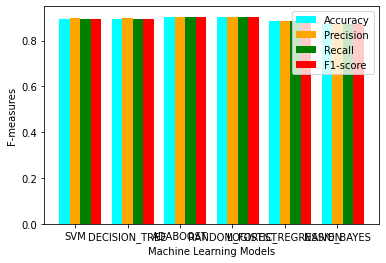

In [ ]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# '6' means 6 ML models performance are going to be shown
x = np.arange(6)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, accuracies, width, color='cyan')
plt.bar(x, precisions, width, color='orange')
plt.bar(x+0.2, recalls, width, color='green')
plt.bar(x+0.4, f1_scores, width, color='red')

plt.xticks(x, ['SVM', 'DECISION_TREE', 'ADABOOST', 'RANDOM_FOREST', 'LOGISTIC_REGRESSION','NAIVE_BAYES'])
plt.xlabel("Machine Learning Models")
plt.ylabel("F-measures")
plt.legend(["Accuracy", "Precision", "Recall","F1-score"])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


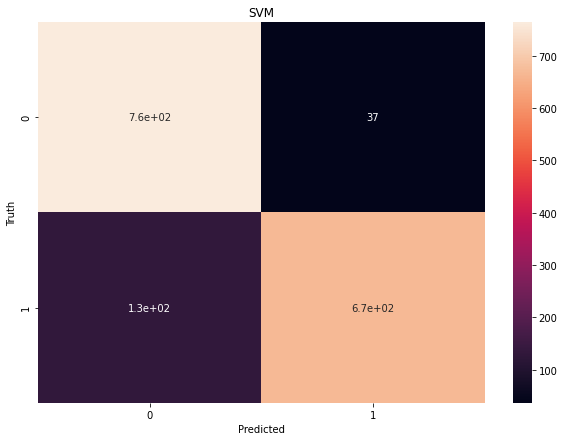

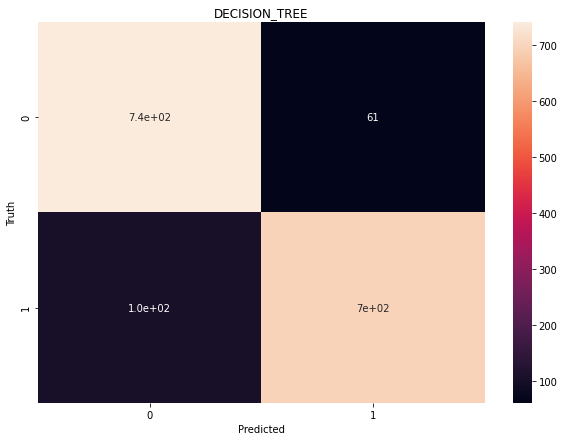

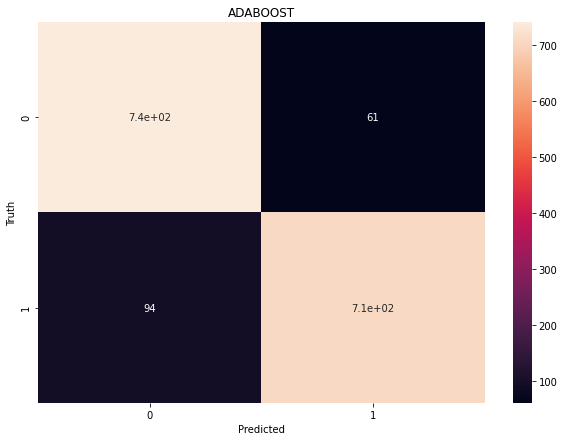

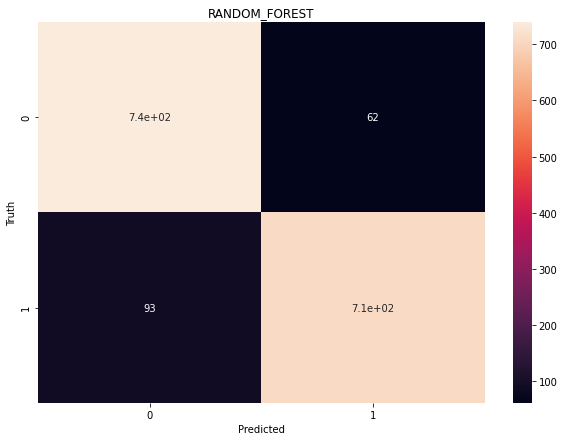

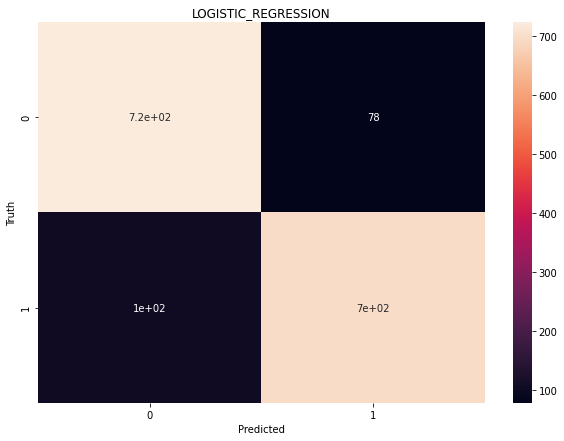

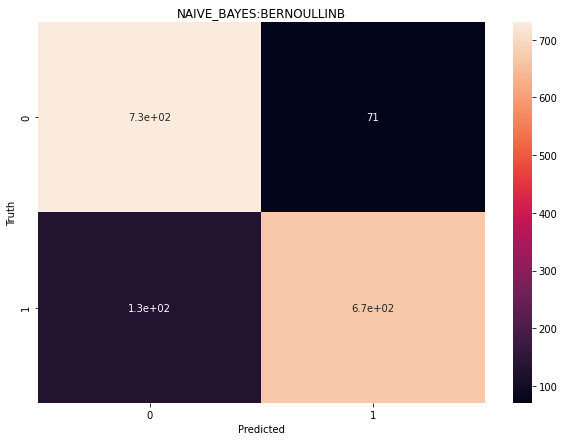

In [ ]:
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt

#Confusion matrix of best classification results of the models
for model_name,matrix in ConfusionMatrix.items():
    #print(model_name)
    plt.figure(figsize = (10,7))
    sn.heatmap(matrix, annot=True)
    plt.title(model_name.upper())
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


# TPOT for Automated Machine Learning

##### Reference


*   https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/



In [ ]:
pip install tpot

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 166.7MB 75kB/s 
     |████████████████████████████████| 163kB 26.2MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=c285f3b8a99d3f74be3bd72946de9a8a44ed6e53e51a5a4abd0a0b7b083fff6c
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import tpot
print('tpot: %s' % tpot.__version__)

tpot: 0.11.7


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [ ]:

# define search
model = TPOTClassifier( generations=10, population_size=50, cv=cv, scoring='f1', verbosity=2, random_state=10, n_jobs=-1)


In [ ]:
# perform the search
model.fit(X, Y)
# export the best model
model.export('tpot_sonar_best_model.py')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Generation 1 - Current best internal CV score: 0.8971717374032798

Generation 2 - Current best internal CV score: 0.8971717374032798

Generation 3 - Current best internal CV score: 0.8987918160856851

Generation 4 - Current best internal CV score: 0.8999931898956692

Generation 5 - Current best internal CV score: 0.8999931898956692

Generation 6 - Current best internal CV score: 0.8999931898956692

Generation 7 - Current best internal CV score: 0.8999931898956692

Generation 8 - Current best internal CV score: 0.8999931898956692

Generation 9 - Current best internal CV score: 0.8999931898956692

Generation 10 - Current best internal CV score: 0.8999931898956692

Best pipeline: MLPClassifier(DecisionTreeClassifier(RobustScaler(input_matrix), criterion=gini, max_depth=1, min_samples_leaf=14, min_samples_split=16), alpha=0.0001, learning_rate_init=0.01)


## AutoML using Pycaret

In [1]:
pip install pycaret

     |████████████████████████████████| 266kB 6.6MB/s 
     |████████████████████████████████| 1.4MB 9.0MB/s 
     |████████████████████████████████| 174kB 22.9MB/s 
     |████████████████████████████████| 276kB 20.4MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 2.0MB 23.2MB/s 
     |████████████████████████████████| 112kB 41.6MB/s 
     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 256kB 40.4MB/s 
     |████████████████████████████████| 14.2MB 245kB/s 
     |████████████████████████████████| 1.7MB 37.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 32.5MB/s 
     |████████████████████████████████| 1.2MB 33.4MB/s 
     |████████████████████████████████| 645kB 20.8MB/s 
     |████████████████████████████████| 10.1MB 27.7MB

In [4]:
pip install sklearn-genetic

     |████████████████████████████████| 163kB 5.6MB/s 


In [16]:
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV

mcc = make_scorer(matthews_corrcoef)
estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)

from sklearn.model_selection import *
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
rkf = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 10)
for i in range(2,11):
  
    selector = GeneticSelectionCV(estimator,
                                cv = rkf,
                                verbose = 0,
                                scoring = mcc,
                                max_features = i,
                                n_population = 200,
                                crossover_proba = 0.5,
                                mutation_proba = 0.2,
                                n_generations = 10,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.05,
                                #tournament_size = 3,
                                n_gen_no_change=10,
                                caching=True,
                                n_jobs=-1)
  
    selector = selector.fit(X, Y)
    genfeats = X.columns[selector.support_]
    genfeats = list(genfeats)
    print("Chosen Feats:  ", genfeats)

cv_score = selector.generation_scores_[-1]
nofeats.append(len(genfeats)) 
chosen_feats.append(genfeats) 
cvscore.append(cv_score)





report["No of Feats"] = nofeats
report["Chosen Feats"] = chosen_feats
report["Scores"] = cvscore






Chosen Feats:   ['Feature0', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature5', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature3', 'Feature5', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature5', 'Feature7', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature5', 'Feature6', 'Feature7', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature5', 'Feature6', 'Feature7', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature2', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature2', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8']
Chosen Feats:   ['Feature0', 'Feature1', 'Feature2', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8']


In [12]:
report["Scores"] = np.round(report["Scores"], 3)
report.sort_values(by = "Scores", ascending = False, inplace = False)
#report.index
ga_feats = report.iloc[0]["Chosen Feats"]

used_feats =  ga_feats.copy()
used_feats.append('ClassLabel')

print(report)
print(ga_feats)


   No of Feats                                       Chosen Feats  Scores
0            2                               [Feature0, Feature8]   0.641
1            3                     [Feature0, Feature5, Feature8]   0.703
2            4           [Feature0, Feature3, Feature5, Feature8]   0.710
3            5  [Feature0, Feature1, Feature3, Feature5, Featu...   0.721
4            6  [Feature0, Feature1, Feature5, Feature6, Featu...   0.737
5            6  [Feature0, Feature1, Feature5, Feature6, Featu...   0.749
6            8  [Feature0, Feature1, Feature2, Feature4, Featu...   0.757
7            8  [Feature0, Feature1, Feature2, Feature4, Featu...   0.749
8            8  [Feature0, Feature1, Feature2, Feature5, Featu...   0.752
['Feature0', 'Feature8']


In [13]:
from pycaret.datasets import get_data
from pycaret.classification import *
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek



ename = setup(data = df[used_feats], target = "ClassLabel", 
              train_size=0.8,
              test_data = None,
              fold_strategy = "stratifiedkfold",
              fold_shuffle = True, 
              use_gpu = True,
              normalize = True,
              categorical_features = None,
              
              #pca = True,
              #pca_method = "kernel",
              #pca_components = 5, 
              preprocess = False,
              html = True,
              #POLYNOMIAL
              #polynomial_features = True,
              #polynomial_degree = 2, 
              #transformation
              
              #transformation = True,
              feature_selection = True, 
              feature_interaction = True,
          
              fix_imbalance = True,
              #fix_imbalance_method  = SMOTE(),
              imputation_type='simple',
              verbose = True,
              )


rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 20)
best_model = compare_models(sort = "MCC", round = 2, 
                            fold = rskf,
                            #include = ["rf","catboost"],
                            #n_select = 1
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.02
knn,K Neighbors Classifier,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.05
nb,Naive Bayes,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.01
dt,Decision Tree Classifier,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.01
svm,SVM - Linear Kernel,0.9,0.00,0.56,0.89,0.69,0.63,0.65,0.01
ridge,Ridge Classifier,0.9,0.00,0.56,0.89,0.69,0.63,0.65,0.01
rf,Random Forest Classifier,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.93
qda,Quadratic Discriminant Analysis,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.01
ada,Ada Boost Classifier,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.26
gbc,Gradient Boosting Classifier,0.9,0.77,0.56,0.89,0.69,0.63,0.65,0.07
